# Molecular dynamics

## Overview
- **Teaching:** 15 min
- **Exercises:** 0 min

**Questions**
- What is the schedule?
- Why does each episode need an overview?
- How do I create my content?

**Objectives**
- Understand why we adopt this structure
- Be able to create content in the schedule and episodes

Now that we have introduced the classical methods, and the complications of these methods, we can discuss how the dynamics of the molecules are obtained. 
The particles that we study are classical in nature, and therefore it is possible to apply classical mechanics to rationalise their dynamic behaviour. 
For this the starting point is **Newton's second law of motion**, 

$$ \mathbf{f} = m\mathbf{a}, $$

where $\mathbf{f}$ is the force on an atom of mass, $m$, and acceleration, $\mathbf{a}$. 
The force between two particles, $i$ and $j$, can be found from the interaction energy, 

$$ f_{ij} = \dfrac{-\text{d}E(r_{ij})}{\text{d}r_{ij}}.$$

Which is to say that the force is the negative of the first derivative of the energy with respect to the distance between them.
The code below creates a function that is capable of calculating the energy or the force from the Lennard-Jones potential, depending on the `force` variable. 
Both the energy and force are then plotted on a single graph.

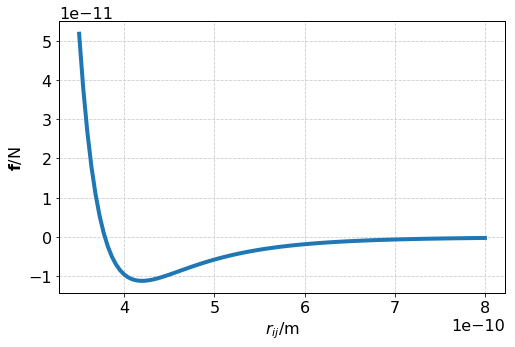

In [51]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import plot_style

def lj(rij, a, b, force):
    """
    Implementation of the Lennard-Jones potential 
    to calculate either the energy or the force.
    
    Parameters
    ----------
    rij: float
        Distance between two particles
    a: float 
        A parameter for interaction
    b: float 
        B parameter for interaction
    force: bool
        If true the force will be determined.
    
    Returns
    -------
    float
        Either the energy or the force of the interaction.
    """
    if force:
        return 12 * a / np.power(rij, 13) - 6 * b / np.power(rij, 7)
    else:
        return a / np.power(rij, 12) - b / np.power(rij, 6)
    
r = np.linspace(3.5e-10, 8e-10, 100)
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(r, lj(r, 1.363e-134, 9.273e-78, True))
ax.set_xlabel(r'$r_{ij}$/m')
ax.set_ylabel(r'$\mathbf{f}$/N')
plt.show()

You may have noticed that in Newton's second law of motion, the force is a vector quantity, whereas the force as the negative of the first derivative of the energy is not. 
This means that it is necessary to convert to obtain the force vector for the relevant dimensionality. 
This is achieved by multiplication by the unit vector in each dimension,

$$ \mathbf{f}_x = f\hat{\mathbf{r}}_x\text{, where }\hat{\mathbf{r}}_x = \dfrac{r_x}{|\mathbf{r}|}. $$

In the above equation, $r_x$ is the distance between the two particles in the $x$-dimension and $\mathbf{r}$ is the overall distance vector. 
The above equation must be determined to find the force in each dimension. 
However, this tutorial will only consider particles interacting in a one-dimensional space. 

The code below shows how to determine the acceleration on each particle due to each other particle. 

In [68]:
mass_of_argon = 39.948 # amu
mass_of_argon_kg = mass_of_argon * 1.6605e-27

def get_accelerations(positions):
    """
    Calculate the acceleration on each particle as a 
    result of each other particle. 
    
    Parameters
    ----------
    positions: ndarray of floats
        The positions, in a single dimension, for all
        of the particles
        
    Returns
    -------
    ndarray of floats
        The acceleration on each particle
    """
    rx = np.zeros((positions.size, positions.size))
    accelerationx = np.zeros((positions.size, positions.size))
    for i in range(0, positions.size):
        for j in range(0, positions.size):
            if i != j:
                rx = positions[j] - positions[i]
                rmag = np.sqrt(rx * rx)
                force = lj(rmag, 1.363e-134, 9.273e-78, True)
                forcex = force * rx / rmag
                accelerationx[i, j] = forcex / mass_of_argon_kg
            else:
                accelerationx[i, j] = 0
    return np.sum(accelerationx, axis=0)

get_accelerations(np.array([1e-10, 5e-10, 10e-10]))

array([ 1.46261847e+14, -5.73558108e+13, -8.89060363e+13])

## Key points
- A lesson requires a schedule and episodes.
- The schedule gives an overview of the workshop and links each episode.
- Each episode needs to be numbered and linked.
- Keywords are used to decorate cells with pre-formatted `html`.